# Imports

In [1]:
import os
import pickle
import random
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.autonotebook import tqdm

from pfc_packages.pointNet import *
from pfc_packages.utils import *

/tmp/ipykernel_128207/4280382460.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Hyperparameters

In [2]:
NUM_CLASSES = 20
INPUT_CHANNELS = 9
EPOCHS = 1000
LR = 0.001
DECAY_RATE = 0.0001
MOMENTUM_DECCAY_STEP = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model configs

In [3]:
# ==== MODEL ====
model = PointNetSeg(num_classes=NUM_CLASSES, input_channels=INPUT_CHANNELS).to(DEVICE)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(
    model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=DECAY_RATE
)

# Pre-process clusters

In [42]:
# # ==== LOAD DATA ====
# # unprocessed_train_dataset = SemanticKittiDataset("../../datasets/semantic-kitti", load_cluster=True, sequence_list= [101])
# unprocessed_train_dataset = SemanticKittiDataset("../../datasets/semantic-kitti", load_cluster=True)

# processed_train_dataset = []
# # count = 0

# for frame in tqdm(unprocessed_train_dataset, desc="Processando frames"):
#     processed_train_dataset.append(
#         extract_features_from_clusters(frame, min_cluster_size=3)
#     )
#     # count += 1
#     # if count == 50:
#     #     break

# # with open("./checkpoints_to_ignore/processed_train_dataset.pkl", "wb") as f:
# #     pickle.dump(processed_train_dataset, f)

with open("./checkpoints_to_ignore/processed_train_dataset.pkl", "rb") as f:
    processed_train_dataset = pickle.load(f)

print(len(processed_train_dataset))

271


In [5]:
max_clusters = max(f.shape[0] for f in processed_train_dataset)
print(max_clusters, len(processed_train_dataset))
print(processed_train_dataset[0][0])

844 271
[60.38326645 17.59372711  2.34032941 60.38326645 17.59372711  2.34032941
 60.38326645 17.59372711  2.34032941  9.          0.        ]


# Train model

In [6]:
loss_history = []
acc_history = []

for epoch in tqdm(range(EPOCHS), desc="Epochs", unit="epoch", position=0):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_points = 0

    random.shuffle(processed_train_dataset)
    for item in tqdm(
        processed_train_dataset,
        desc=f"Frame",
        unit="frame",
        leave=False,
        position=1,
    ):
        # for item in tqdm(processed_train_dataset, desc=f"Frame (Epoch {epoch+1}/{EPOCHS})", unit="frame"):
        data = (
            torch.tensor(item[:, :INPUT_CHANNELS], dtype=torch.float32)
            .unsqueeze(0)
            .to(DEVICE)
        )
        label = torch.tensor(item[:, -2], dtype=torch.long).unsqueeze(0).to(DEVICE)

        optimizer.zero_grad()
        pred, trans = model(data)
        pred = pred.view(-1, NUM_CLASSES)
        label = label.view(-1)

        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (pred.argmax(dim=1) == label).sum().item()
        total_points += label.numel()

    avg_loss = total_loss / len(processed_train_dataset)
    avg_acc = total_correct / total_points
    loss_history.append(avg_loss)
    acc_history.append(avg_acc)

print(f"[Epoch {epoch:05d}] Loss: {avg_loss:.4f} | Acc: {avg_acc*100:.2f}%")
# Opcional: salvar checkpoints
torch.save(model.state_dict(), f"checkpoints_to_ignore/pointnet_epoch_{EPOCHS+1:03d}_9chan.pth")

Epochs:   0%|          | 0/1000 [00:00<?, ?epoch/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

Frame:   0%|          | 0/271 [00:00<?, ?frame/s]

[Epoch 00999] Loss: 0.0429 | Acc: 98.46%


In [7]:
# from torch.utils.data import DataLoader, TensorDataset

# # Supondo que processed_train_dataset seja uma lista de arrays (N, C)
# # Concatene todos os frames em um único array
# all_data = np.concatenate([item[:, :INPUT_CHANNELS] for item in processed_train_dataset], axis=0)
# all_labels = np.concatenate([item[:, -2] for item in processed_train_dataset], axis=0)

# dataset = TensorDataset(
#     torch.tensor(all_data, dtype=torch.float32),
#     torch.tensor(all_labels, dtype=torch.long)
# )
# loader = DataLoader(dataset, batch_size=32, shuffle=True)

# for epoch in range(EPOCHS):
#     for data, label in loader:
#         # data: (B, INPUT_CHANNELS)
#         # label: (B,)
#         # ... seu código ...

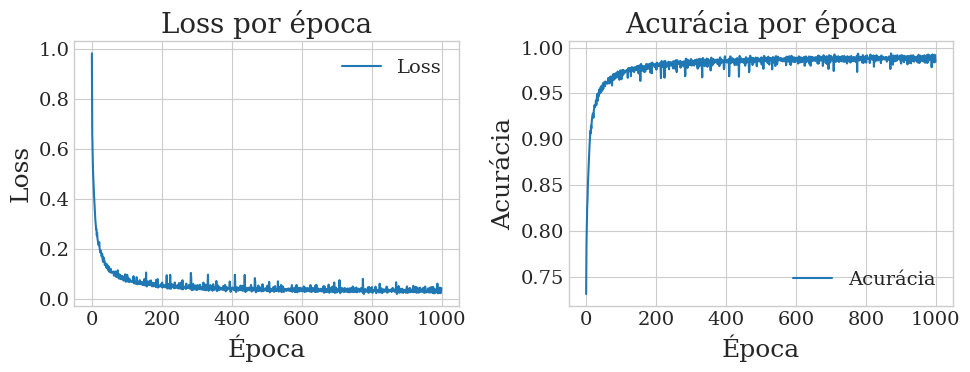

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Loss por época")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_history, label="Acurácia")
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Acurácia por época")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Inference

In [45]:
point_cloud = processed_train_dataset[20]

data = (
    torch.tensor(point_cloud[:, :INPUT_CHANNELS], dtype=torch.float32)
    .unsqueeze(0)
    .to(DEVICE)
)
label = point_cloud[:, -2]

# # Carregar o modelo treinado
# model = PointNetSeg(num_classes=NUM_CLASSES).to(DEVICE)
# model.load_state_dict(torch.load("checkpoints/pointnet_epoch_001.pth"))

model.eval()
with torch.no_grad():
    pred, trans = model(data)
    pred = pred.view(-1, NUM_CLASSES)

    # pred_labels = torch.argmax(pred, dim=1).cpu().numpy()
    pred = pred.argmax(dim=1)

# Agora, substituindo os rótulos originais pelos rótulos preditos
# Mantendo as coordenadas xyz no formato original e substituindo o label
result = np.hstack(
    (
        data.squeeze(0).cpu().numpy(),
        label.reshape(-1, 1),
        pred.cpu().numpy().reshape(-1, 1),
    )
)

In [46]:
# Calcula a acurácia usando o array result
true_labels = result[:, -2]
pred_labels = result[:, -1]
accuracy = (true_labels == pred_labels).sum() / len(result)
print(f"Acurácia (amostra): {accuracy*100:.2f}%")
# print(f"[Epoch {epoch:05d}] Loss: {avg_loss:.4f} | Acc: {avg_acc*100:.2f}%")
run_viz(
    result,
    cluster_viz=True,
    show_pred_label=True,
    point_size=3,
    # show_min_max=True,
)
run_viz(
    result,
    cluster_viz=True,
    show_true_label=True,
    point_size=3,
    # show_min_max=True,
)

Acurácia (amostra): 58.63%
